In [20]:
from prospect.io import read_results as pread
import matplotlib.pyplot as plt
out_file = '/home/s.lower/scripts/jupyter_analysis_notebooks/prospector_tutorial/simba_example.h5'
results = pread.results_from(out_file)

In [2]:
from prospect.models import priors, transforms #helper functions for specifying priors
from prospect.models import sedmodel
def build_model_2(**kwargs):
    
    """
    Function to build model components for SFH and dust. 
    The model params are defined by their name, whether they are a free parameter
    their initial value, and their prior distribution if they are variable. The model 
    params are then fed to the prospector SedModel class
    
    All parameters except 'mass' correspond to fsps model parameters, the definitions of which you can find here:
    https://dfm.io/python-fsps/current/stellarpop_api/
    
    This time, we will be using something called a non-parametric star formation history model. You don't
    _really_ need to understand this in detail, but if you want to read up on it here's a few places to start:
    https://arxiv.org/abs/1811.03637
    https://arxiv.org/abs/2006.03599
    
    The 
    
    """
    
    model_params = []
    #redshift of galaxy. Working with simulated data is weird in that our galaxy is at redshift 0, specifically
    #our observed SED is at a luminosity distance of 10 pc --> completely unphysical in the real Universe but 
    #ultimately doesn't matter because we can just fix that value in our model
    model_params.append({'name': "zred", "N": 1, "isfree": False,"init": 0.1, 'prior': None})
    model_params.append({'name': "lumdist", "N": 1, "isfree": False,"init": 1e-5, 'units': 'Mpc'})
    #IMF model which will be used by the simple stellar population model
    model_params.append({'name': 'imf_type', 'N': 1,'isfree': False,'init': 2, 'prior': None})
    #stellar mass
    model_params.append({'name': 'logmass', 'N': 1,'isfree': True, 'init': 10.0,'prior': priors.TopHat(mini=8, maxi=12)})
    #stellar metallicity
    model_params.append({'name': 'logzsol', 'N': 1,'isfree': True,'init': -0.5,'prior': priors.TopHat(mini=-1.6, maxi=0.1)})
    #non parametric SFH model
    #essentially, this model is comprised of a handful of piece-wise bins of constant SFR. the prior on the 
    # normalization (shape) of the SFH is a Dirichlet distribution 
    model_params.append({'name': "sfh", "N": 1, "isfree": False, "init": 3})
    #here, mass =/= the total stellar mass, but rather the stellar mass in each bin of constant SFR
    # these parameters depend on the z_fraction parameters through a conversion
    model_params.append({'name': "mass", 'N': 3, 'isfree': False, 'init': 1., 'depends_on':zfrac_to_masses_log})
    model_params.append({'name': "agebins", 'N': 1, 'isfree': False,'init': []})
    # this proxy parameter is what's actually varied in the SFH model
    model_params.append({'name': "z_fraction", "N": 2, 'isfree': True, 'init': [0, 0],'prior': priors.Beta(alpha=1.0, beta=1.0, mini=0.0, maxi=1.0)})
    #dust attenuation model, from Kriek & Conroy 2013, this time we allow a variable attenuation curve slope
    model_params.append({'name': 'dust_type', 'N': 1,'isfree': False,'init': 4,'prior': None})
    #the attenuation (in magnitudes) in the V-band
    model_params.append({'name': 'dust2', 'N': 1,'isfree': True, 'init': 0.1,'prior': priors.ClippedNormal(mini=0.0, maxi=2.0, mean=0.0, sigma=0.3)})
    #the attenuation (in magnitudes) in the V-band
    model_params.append({'name': 'dust_index', 'N': 1,'isfree': True, 'init': -0.3,'prior': priors.TopHat(mini=-1.6, maxi=0.3)})
    #dust emission model -- only 1 choice, from Draine & Li 2007
    model_params.append({'name': 'add_dust_emission', 'N': 1,'isfree': False,'init': 1,'prior': None})
    #mass fraction of warm dust
    model_params.append({'name': 'duste_gamma', 'N': 1,'isfree': True,'init': 0.01,'prior': priors.TopHat(mini=0.0, maxi=1.0)})
    #minimum radiation field
    model_params.append({'name': 'duste_umin', 'N': 1,'isfree': True,'init': 1.0,'prior': priors.TopHat(mini=0.1, maxi=20.0)})
    #mass fraction of dust in PAHs
    model_params.append({'name': 'duste_qpah', 'N': 1,'isfree': False,'init': 5.86,'prior': priors.TopHat(mini=0.0, maxi=6.0)})
    
    #now modify our SFH model to our specifications
    n = [p['name'] for p in model_params]
    tuniv = 14.0
    nbins=6 #6 bins of constant SFR
    tbinmax = (tuniv * 0.85) * 1e9
    lim1, lim2 = 8.0, 8.52 #100 Myr and 330 Myr                                                                                                              \                                                                                                                                                       
    agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]
    agebins = np.array([agelims[:-1], agelims[1:]])
    ncomp = nbins
    alpha_sfh = 0.7  # desired Dirichlet concentration                                                                                                       \                                                                                                                                                   
    alpha = np.repeat(alpha_sfh,nbins-1)
    tilde_alpha = np.array([alpha[i-1:].sum() for i in range(1,ncomp)])
    zinit = np.array([(i-1)/float(i) for i in range(ncomp, 1, -1)])
    zprior = priors.Beta(alpha=tilde_alpha, beta=np.ones_like(alpha), mini=0.0, maxi=1.0)
    model_params[n.index('mass')]['N'] = ncomp
    model_params[n.index('agebins')]['N'] = ncomp
    model_params[n.index('agebins')]['init'] = agebins.T
    model_params[n.index('z_fraction')]['N'] = len(zinit)
    model_params[n.index('z_fraction')]['init'] = zinit
    model_params[n.index('z_fraction')]['prior'] = zprior
    
    model = sedmodel.SedModel(model_params)
    return model

def zfrac_to_masses_log(logmass=None, z_fraction=None, agebins=None, **extras):
    sfr_fraction = np.zeros(len(z_fraction) + 1)
    sfr_fraction[0] = 1.0 - z_fraction[0]
    for i in range(1, len(z_fraction)):
        sfr_fraction[i] = np.prod(z_fraction[:i]) * (1.0 - z_fraction[i])
    sfr_fraction[-1] = 1 - np.sum(sfr_fraction[:-1])
    time_per_bin = np.diff(10**agebins, axis=-1)[:, 0]
    mass_fraction = sfr_fraction * np.array(time_per_bin)
    mass_fraction /= mass_fraction.sum()

    masses = 10**logmass * mass_fraction
    return masses

In [3]:
from prospect.sources import FastStepBasis
def build_sps_2(**kwargs):
    """
    This is our stellar population model which generates the spectra for stars of a given age and mass. 
    Because we are using a non parametric SFH model, we do have to use a different SPS model than before 
    """
    sps = FastStepBasis(zcontinuous=1)
    return sps

In [4]:
model = build_model_2()
sps = build_sps_2()

In [5]:
model.theta_labels()

['logmass',
 'logzsol',
 'z_fraction_1',
 'z_fraction_2',
 'z_fraction_3',
 'z_fraction_4',
 'z_fraction_5',
 'dust2',
 'dust_index',
 'duste_gamma',
 'duste_umin']

Because the Draine & Li 2007 dust emission model doesn't directly fit for the dust mass, we need to compute that given the model posteriors. We'll do this using fsps, which containts the function to calculate the dust mass for a given stellar population & set of dust properties.

First, lets see how to calculate the dust mass from one set of parameters. The basic idea is that we'll take the model parameters and generate a stellar population from those parameters with which fsps will calculate the dust mass corresponding to those parameter values. Though the dust emission model only depends on 3 parameters (and in our case, 2), the dust mass calculation depends on the stellar properties as well, namely stellar mass and the star formation history. 

In [7]:
parameter_chain = results[0]['chain'][0]
params = model.theta_labels()
for i in range(len(parameter_chain)):
    print(f'{params[i]} = {parameter_chain[i]}')

logmass = 11.946634074766118
logzsol = -1.0449219184876242
z_fraction_1 = 0.48314395841208246
z_fraction_2 = 0.3512908499986519
z_fraction_3 = 0.36871396327838896
z_fraction_4 = 0.781684208611392
z_fraction_5 = 0.09495747414386811
dust2 = 0.3381443412811902
dust_index = -0.7482194817543889
duste_gamma = 0.5063365032992527
duste_umin = 4.779965250929581


Since we're working with the Simba data that was fit with a non-parametric SFH, we do have to do a bit of work to input it into our fsps stellar population

In [17]:
total_mass = 10**parameter_chain[params.index('logmass')]
time_bins_log = model.params['agebins']
z_frac = parameter_chain[params.index('z_fraction_1'):params.index('z_fraction_5')+1]

print(f'Total stellar mass: {total_mass}')
print(f'SFH bins in log(Gyr): \n{time_bins_log}')
print(f'SFR parameters before conversion: {z_frac}')

Total stellar mass: 884370148538.261
SFH bins in log(Gyr): 
[[ 0.          8.        ]
 [ 8.          8.52      ]
 [ 8.52        9.03851565]
 [ 9.03851565  9.55703131]
 [ 9.55703131 10.07554696]
 [10.07554696 10.14612804]]
SFR parameters before conversion: [0.48314396 0.35129085 0.36871396 0.78168421 0.09495747]


Prospector comes with a couple of conversion functions that take our non-parametric SFHs and convert them into forms that we can understand a bit easier (i.e., the amount of stellar mass produced in each time range) 

In [25]:
from prospect.models.transforms import zfrac_to_masses
masses = zfrac_to_masses(total_mass, z_frac, time_bins_log)
converted_sfh = sps.convert_sfh(time_bins_log, masses)

Text(0.5, 0, 'Age of Universe [Gyr]')

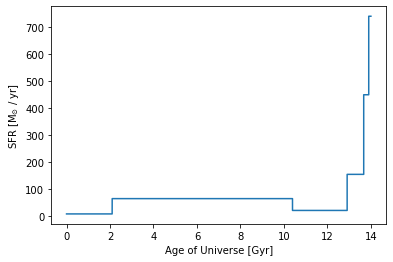

In [29]:
plt.plot(converted_sfh[0],converted_sfh[1])
plt.ylabel('SFR [M$_{\odot}$ / yr]')
plt.xlabel('Age of Universe [Gyr]')

Now, we can take our model parameters and use them to calculate the dust mass using fsps (inside of prospector)

In [34]:
model_sp = sps.ssp
model_sp.params['sfh'] = 3 #this tells fsps that we are using a non-parametric SFH
model_sp.set_tabular_sfh(converted_sfh[0], converted_sfh[1])
#copying these three fixed model params from our model setup                                                                                                                          
model_sp.params['imf_type'] = 2
model_sp.params['zred'] = 0.0
#and inputting our dust model parameters below
model_sp.params['add_dust_emission'] = True
model_sp.params['dust_type'] = 5
model_sp.params['dust2'] = parameter_chain[params.index('dust2')]
model_sp.params['dust_index'] = parameter_chain[params.index('dust_index')]
model_sp.params['logzsol'] = parameter_chain[params.index('logzsol')]
model_sp.params['duste_gamma'] = parameter_chain[params.index('duste_gamma')]
model_sp.params['duste_umin'] = parameter_chain[params.index('duste_umin')]
model_sp.params['duste_qpah'] = 5.86
dust_mass = model_sp.dust_mass[-1]

In [39]:
print(f'Our model dust mass is {dust_mass} M_sun')

Our model dust mass is 12961239.258520622 M_sun


But this is just for a random (not really random, just the first) sample drawn from our model posteriors....we really need to use the values from the posterior that best describe our observed SED. To do that, we'll use what are called the maximum likelihood estimates. _Technically_ we should be using the entire posterior distrubtions to generate a posterior distribution for the dust mass (i.e., do the above calculation for _every_ posterior sample drawn during the fit) but that would take a bit longer and would needlessly complicate things, at least for our purposes here. 

Anyways, the maximum likelihood estimates are exactly that -- the value of each parameter posterior distribution that has the highest probability of matching the true galaxy properties. Luckily for us, the prospector output stores the likelihood estimate for each sample drawn during the fit so all we need to do is ask for the parameter values with the maximum likelihood!

In [41]:
def get_best(results):
    imax = np.argmax(results['lnprobability']) #which parameter sample during the fit had the highest likelihood?
    theta_best = results['chain'][imax, :].copy()
    return theta_best

In [42]:
max_params = get_best(results[0])

In [43]:
print('Best fit parameters:')
for i in range(len(parameter_chain)):
    print(f'{params[i]} = {max_params[i]}')

Best fit parameters:
logmass = 10.40338147877568
logzsol = -0.6072854116650553
z_fraction_1 = 0.8671190060245757
z_fraction_2 = 0.9331741584157118
z_fraction_3 = 0.904171762058183
z_fraction_4 = 0.7847015157906547
z_fraction_5 = 0.0007793055429786896
dust2 = 0.06730655033941126
dust_index = -1.2338107627988595
duste_gamma = 0.01841811949766964
duste_umin = 2.325709388848862


So now we just repeat what we did above but with these parameters 

In [44]:
total_mass = 10**max_params[params.index('logmass')]
time_bins_log = model.params['agebins']
z_frac = max_params[params.index('z_fraction_1'):params.index('z_fraction_5')+1]

masses = zfrac_to_masses(total_mass, z_frac, time_bins_log)
converted_sfh = sps.convert_sfh(time_bins_log, masses)

model_sp.params['sfh'] = 3 #this tells fsps that we are using a non-parametric SFH
model_sp.set_tabular_sfh(converted_sfh[0], converted_sfh[1])
#copying these three fixed model params from our model setup                                                                                                                          
model_sp.params['imf_type'] = 2
model_sp.params['zred'] = 0.0
#and inputting our dust model parameters below
model_sp.params['add_dust_emission'] = True
model_sp.params['dust_type'] = 5
model_sp.params['dust2'] = parameter_chain[params.index('dust2')]
model_sp.params['dust_index'] = parameter_chain[params.index('dust_index')]
model_sp.params['logzsol'] = parameter_chain[params.index('logzsol')]
model_sp.params['duste_gamma'] = parameter_chain[params.index('duste_gamma')]
model_sp.params['duste_umin'] = parameter_chain[params.index('duste_umin')]
model_sp.params['duste_qpah'] = 5.86
dust_mass = model_sp.dust_mass[-1]

In [45]:
print(f'Our best fit model dust mass is {dust_mass} M_sun')

Our best fit model dust mass is 299714.70972572465 M_sun
